<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [79]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
import re
import en_core_web_lg
nlp = en_core_web_lg.load()

yelp = pd.read_json('review_sample.json', lines=True)

In [16]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [72]:
def tokenize(doc):
    doc = nlp(doc)
    return [token.lemma_ for token in doc if ((token.is_punct != True) and 
                                              (token.lemma_ != '-PRON-') and 
                                              (token.is_stop == False))]

In [73]:
# Prove the function works
print(tokenize(yelp['text'][0]))

['beware', 'fake', 'fake', 'fake', 'small', 'business', 'Los', 'Alamitos', 'receive', 'look', 'like', 'legitimate', 'bill', '$', '70', 'account', 'number', ' ', 'call', 'phone', 'number', 'list', '866', '273', '7934', ' ', 'wait', 'time', 'hold', 'say', '20', 'minute', 'leave', 'message', ' ', 'live', 'person', 'phone', 'matter', 'number', 'select', ' ', 'leave', 'firm', 'message', 'contact', 'BBB', 'attorney', 'company', 'try', 'scam', 'business', 'illegal']


## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [24]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(yelp['text'])

# View Feature Matrix as DataFrame
docs = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
docs.head()

,00,000,00pm,07,10,100,1000,101,10pm,11,...,yuck,yuk,yum,yummy,yup,zero,zone,zoo,zucchini,était
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Instantiate the model
nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')

# Fit on TF-IDF Vectors
nn.fit(dtm.todense())

fake_review = ['worst food and service ever']

# Transform the new review and then compare it to the rest
new = tfidf.transform(fake_review)
neighborhood = nn.kneighbors(new.todense())

In [33]:
list(neighborhood[1][0])

[6204, 6311, 9020, 6847, 2406, 753, 7374, 3963, 9415, 9169]

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [35]:
# Cleaner code by abstracting the columns to X and y
X = yelp['text']
y = yelp['stars']

# Instantiate the various objects
vectorizer = TfidfVectorizer(stop_words='english', max_features = 10000)
sgdc  = SGDClassifier()
pipe = Pipeline([('vect', vectorizer), ('sgdc', sgdc)])

# Fit the combined pipe model, and then test it with cross_val
pipe.fit(X, y)
score = (cross_val_score(pipe, X, y, 
                          cv = 10, 
                          scoring = 'accuracy',
                          n_jobs = -1,
                          verbose = 10)).mean()

# Not a great score but that isn't what I'm being tested on
print(score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   14.4s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   14.6s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   15.9s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.9s finished


0.6147988045052679


In [48]:
# Try a few fake reviews including the one from before
fake_reviews = ['came here for lunch. waiter was quick. waiter was friendly.', 'worst food and service ever', '5 4 3 2 1 blast off!']
preds = pipe.predict(fake_reviews)

# It works, particularly like that the last review gets 5 stars
list(preds)

[4, 1, 5]

In [50]:
# Set up and run grid search to tune our model
parameters = {'vect__max_df': (0.5, 0.75, 1.0),
              'sgdc__max_iter':(20, 10, 100)}

grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   39.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'sgdc__max_iter': (20, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [56]:
# Show it worked by displaying the top 2 variations of parameters
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head(2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdc__max_iter,param_vect__max_df,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,1.500723,0.048736,0.283921,0.011674,20,1,"{'sgdc__max_iter': 20, 'vect__max_df': 1.0}",0.603397,0.608696,0.6085,...,0.6074,0.002344,1,0.901225,0.902238,0.90200,0.902387,0.897901,0.901150,0.001673
1,1.575603,0.085445,0.290161,0.012480,20,0.75,"{'sgdc__max_iter': 20, 'vect__max_df': 0.75}",0.603397,0.609695,0.6055,...,0.6068,0.002640,2,0.900850,0.901863,0.90225,0.902887,0.897276,0.901025,0.001988


## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [74]:
def format_data(reviews):
    data = []
    for review in reviews: 
        tokens = tokenize(review)
        data.append(tokens)
    return data

In [75]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(format_data(X))

# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.85)

corpus = [id2word.doc2bow(text) for text in format_data(X)]

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 5,
                   passes=5,
                   workers=4)

In [76]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:3]) for t in words]

# Terrible "topics" but LDA-vis below helps us to better interpret what these topics are
print(topics)

['  good food', '\n\n   good', '\n \n\n place', '  \n\n time', '  good great']


In [86]:
def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = format_data(X)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        path=format_data(X),
                                                        start=2,
                                                        limit=6,
                                                        step=1)

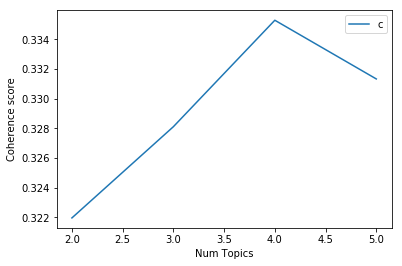

In [91]:
import matplotlib.pyplot as plt

# Corrected plot, inflection at 4 indicates ideal of 4 topics
limit=6; start=2; step=1;
x = list(range(start, limit))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [80]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.087098 -0.014815       1        1  29.399035
3      0.104488 -0.024673       2        1  26.709915
2      0.026492 -0.008293       3        1  16.418880
4      0.008941  0.065269       4        1  14.974901
0     -0.052823 -0.017488       5        1  12.497272, topic_info=    Category          Freq        Term         Total  loglift  logprob
0    Default  14005.000000              14005.000000  30.0000  30.0000
280  Default   3098.000000          \n   3098.000000  29.0000  29.0000
38   Default   6304.000000        good   6304.000000  28.0000  28.0000
129  Default   4787.000000        food   4787.000000  27.0000  27.0000
115  Default   5151.000000       place   5151.000000  26.0000  26.0000
182  Default   4244.000000       great   4244.000000  25.0000  25.0000
43   Default   3542.000000     service   3542.000000  24.0000  24.0000
35   Default   3912.000000        come   3912.000000  23.0000  23.0000
32   Default   4307.000000        time   4307.000000  22.0000  22.0000
297  Default   1234.000000   delicious   1234.000000  21.0000  21.0000
160  Default   1275.000000        menu   1275.000000  20.0000  20.0000
940  Default   1225.000000     chicken   1225.000000  19.0000  19.0000
596  Default    544.000000       cream    544.000000  18.0000  18.0000
95   Default   1129.000000        room   1129.000000  17.0000  17.0000
575  Default   2175.000000        love   2175.000000  16.0000  16.0000
301  Default    866.000000        dish    866.000000  15.0000  15.0000
322  Default   3520.000000       order   3520.000000  14.0000  14.0000
327  Default    713.000000       pizza    713.000000  13.0000  13.0000
127  Default   1567.000000         eat   1567.000000  12.0000  12.0000
524  Default   1387.000000       drink   1387.000000  11.0000  11.0000
441  Default    739.000000      flavor    739.000000  10.0000  10.0000
132  Default   1086.000000         fry   1086.000000   9.0000   9.0000
290  Default    772.000000      cheese    772.000000   8.0000   8.0000
308  Default    955.000000       fresh    955.000000   7.0000   7.0000
626  Default    826.000000       store    826.000000   6.0000   6.0000
44   Default   1518.000000       staff   1518.000000   5.0000   5.0000
895  Default    583.000000      coffee    583.000000   4.0000   4.0000
10   Default    849.000000        call    849.000000   3.0000   3.0000
55   Default   1077.000000         bar   1077.000000   2.0000   2.0000
244  Default    401.000000        nail    401.000000   1.0000   1.0000
..       ...           ...         ...           ...      ...      ...
35    Topic5    848.630493        come   3912.115723   0.5514  -4.2269
38    Topic5   1193.117310        good   6304.670898   0.4149  -3.8862
160   Topic5    340.165253        menu   1275.627197   0.7579  -5.1411
575   Topic5    497.973267        love   2175.629883   0.6051  -4.7600
0     Topic5   1878.983276              14005.090820   0.0710  -3.4321
129   Topic5    864.972290        food   4787.006836   0.3687  -4.2078
32    Topic5    794.379700        time   4307.208008   0.3892  -4.2930
895   Topic5    185.903488      coffee    583.353149   0.9361  -5.7453
290   Topic5    225.603607      cheese    772.995728   0.8482  -5.5518
115   Topic5    863.922302       place   5151.756348   0.2940  -4.2091
171   Topic5    322.424347     amazing   1350.668701   0.6472  -5.1947
297   Topic5    298.273834   delicious   1234.042114   0.6596  -5.2725
182   Topic5    620.724670       great   4244.383301   0.1572  -4.5396
327   Topic5    197.001144       pizza    713.321106   0.7929  -5.6873
940   Topic5    273.080933     chicken   1225.114014   0.5786  -5.3608
308   Topic5    232.738953       fresh    955.436218   0.6674  -5.5206
34    Topic5    318.229889        wait   1664.035156   0.4254  -5.2078
33    Topic5    407.077789         try   2584.334229   0.2314  -4.9615
43    Topic5    478.703857   

### In markdown, write 1-2 paragraphs of analysis on the results of your topic model

My topic model doesn't return great topic words due to poor cleaning in my tokenize method, I could have filtered out new line characters and extended stopwords. Unfortunately due to how long the runtimes of certain cells are, it's difficult to quickly iterate and correct, so I'll be analyzing what I have available so I can submit on time. 

First up, is modeling coherence values to find the optimal number of topics. This is done by graphing the coherence values and looking for the point of greatest inflection, that is the optimal number of topics. If the graph has multiple extreme inflections, like we saw in lecture yesterday, it may point to poor input that needs further cleaning. 

The second visualization shows the fit of an LDA topic to our corpus. Each topic is a circle and a quality check for the model is to minimize overlap of topics. In the above visualization, the overlap of topics 1 and 5 indicates that 5 is likely a subtopic of 1. On the right side, you have the top 30 words for each topic. Red bars represent estimated number of times a given term was generated by a topic and blue bars represent the overall frequency of the term in the corpus. Using this we can get a better sense of our topics: 
- 1 & 5 = Discuss restraunts with 5 being more breakfast oriented so by looking at the words we better understand the overlap. 
- 2 = Services such as hair and nail salon
- 4 = Seems to be activity driven with words like bowling and karaoke but is hampered by the poor data cleaning
- 3 = Has quite a few foreign words that muddy the waters but seems to indicate more social places like the library, mall, and bars

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)